# Bee Colony Loss & Health Throughout America
## Where are bees dying in America, and what is the cause of their deaths?

In [788]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import shapely
import fiona

Set default figuresize and font value

In [820]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 13}
matplotlib.rc('font', **font)

Column name replacement function

In [805]:
def replacement_columns(df, this, with_this):
    df.columns = [x.replace(this, with_this) for x in df.columns]
    return df.columns

### Reading the Data

In [806]:
loss_data = pd.read_excel("colony_loss.xlsx")
loss_data.iloc[98:108]

,Year,Season,State,Total Annual Loss,Beekeepers,Beekeepers Exclusive to State,Colonies,Colonies Exclusive to State
98,2015/16,Annual,Iowa,0.588,48,0.958,1256,0.640
99,2015/16,Annual,Utah,0.594,38,0.868,15873,0.028
100,2015/16,Annual,Delaware,0.602,21,0.762,25674,0.006
101,2015/16,Annual,Mississippi,0.713,12,0.667,22399,0.003
102,2015/16,Annual,Puerto Rico,NaN,1,1.000,1,1.000
103,2015/16,Annual,Alaska,NaN,2,1.000,7,1.000
104,2014/15,Annual,Hawaii,0.139,28,1.000,12093,1.000
105,2014/15,Annual,Oregon,0.252,142,0.944,44306,0.293
106,2014/15,Annual,South Carolina,0.262,71,0.887,2853,0.203
107,2014/15,Annual,Nevada,0.267,7,0.714,1853,0.019


### Cleaning the Data & Column Issues

Replace \xa0 with nothing.
Replace space with nothing.
Change the "State" column name to match the GeoJson, "NAME".
Remove all rows with a NaN value, e.g. Puerto Rico.

In [849]:
replacement_columns(loss_data, '\xa0', '')
replacement_columns(loss_data, ' ', '') 
replacement_columns(loss_data, 'State', 'NAME')
loss_data.dropna(how='any',axis='index', inplace=True)

loss_data.sample(5)

,Year,Season,TotalAnnualLoss,Beekeepers,Colonies
NAME,,,,,
Colorado,2014/15,Annual,0.380,178,84676
Texas,2010/11,Annual,0.302,37,44896
Missouri,2012/13,Annual,0.334,74,1243
Kentucky,2015/16,Annual,0.345,71,829
Wyoming,2015/16,Annual,0.383,26,26403


### Removing Unnecessary Data

Removed all inter-state information, as its extent is undefined
Removed the 'index' column to assist in later code

In [808]:
loss_data = loss_data.set_index("NAME")
loss_data = loss_data.drop(['MultiStateOperation'], axis=0) 
loss_data = loss_data.drop(['BeekeepersExclusivetoNAME', 'ColoniesExclusivetoNAME'], axis=1)

In [809]:
loss_data.sample(5)

,Year,Season,TotalAnnualLoss,Beekeepers,Colonies
NAME,,,,,
Rhode Island,2016/17,Annual,0.447,15,76
New Mexico,2012/13,Annual,0.606,9,71
Oregon,2014/15,Annual,0.252,142,44306
Utah,2016/17,Annual,0.532,167,3302
New Jersey,2013/14,Annual,0.398,165,27002


Taking each value for Beekeeepers, Colonies and TotalAnnualLoss over the 7 year period, and averaging them out. They will be combined into a single row of data later.

In [850]:
loss_beekeepers = loss_data.groupby(["NAME"]).Beekeepers.mean().round(decimals=3)
loss_colonies = loss_data.groupby(["NAME"]).Colonies.mean().round(decimals=3)
loss_annual_loss = loss_data.groupby(["NAME"]).TotalAnnualLoss.mean().round(decimals=3)

Histogram gives an idea of the general percentage distribution of loss among the separate states.

Text(0, 0.5, 'Number of States')

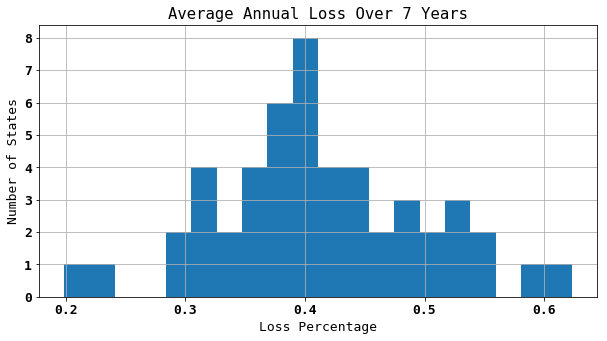

In [851]:
loss_annual_loss.hist(bins=20)
plt.title("Average Annual Loss Over 7 Years")
plt.xlabel("Loss Percentage")
plt.ylabel("Number of States")

### Plotting Geographically

In [852]:
country = gpd.read_file("gz_2010_us_040_00_5m.json")
country.sample(10)

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
43,0400000US48,48,Texas,,261231.711,"(POLYGON ((-97.134356 27.896329, -97.1336 27.8..."
24,0400000US28,28,Mississippi,,46923.274,"(POLYGON ((-89.095623 30.231767, -89.077259 30..."
18,0400000US22,22,Louisiana,,43203.905,"(POLYGON ((-88.865067 29.752714, -88.889754999..."
13,0400000US17,17,Illinois,,55518.930,"POLYGON ((-89.36603100000001 42.500274, -89.36..."
14,0400000US18,18,Indiana,,35826.109,"POLYGON ((-84.802483 40.528046, -84.802547 40...."
17,0400000US21,21,Kentucky,,39486.338,"(POLYGON ((-89.485106 36.497692, -89.492537 36..."
49,0400000US55,55,Wisconsin,,54157.805,"(POLYGON ((-90.403306 47.026693, -90.403321000..."
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03859799999999 38.791513, -77.03..."
22,0400000US26,26,Michigan,,56538.901,"(POLYGON ((-85.82595499999999 45.404296, -85.8..."
23,0400000US27,27,Minnesota,,79626.743,"POLYGON ((-92.204691 46.704041, -92.205692 46...."


### Removing Unnecessary Data & Merging Data

LSAD is an empty column that came with the GeoJson, and there isn't any need to work with census areas.

In [853]:
country = country.drop(['LSAD', 'CENSUSAREA'], axis=1) 
country_loss = pd.merge(country, loss_annual_loss, how='outer', on='NAME')
country_loss = pd.merge(country_loss, loss_beekeepers, how='outer', on='NAME')
country_loss = pd.merge(country_loss, loss_colonies, how='outer', on='NAME')

Removed Alaska and Puerto Rico due to their NaN values under Total Annual Loss.
Also removed both of them and Hawaii as their ecology/ecosystem is different to the USA mainland.

In [854]:
c48 = country_loss[country_loss['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False] # Bye, bye, Puerto Rico!
c48 = c48.set_index("GEO_ID")
c48.sample(5)

,STATE,NAME,geometry,TotalAnnualLoss,Beekeepers,Colonies
GEO_ID,,,,,,
0400000US24,24,Maryland,"(POLYGON ((-76.048373 38.12055, -76.056811 38....",0.500,140.714,16145.571
0400000US11,11,District of Columbia,"POLYGON ((-77.03859799999999 38.791513, -77.03...",0.623,9.400,599.200
0400000US06,06,California,"(POLYGON ((-122.421439 37.869969, -122.421341 ...",0.357,187.429,380262.286
0400000US05,05,Arkansas,"POLYGON ((-94.042964 33.019219, -94.043036 33....",0.376,41.857,3188.286
0400000US16,16,Idaho,"POLYGON ((-111.044156 43.020052, -111.044129 4...",0.289,31.857,76720.286


### Finding Centroids for Geographic Plotting

In [855]:
def state_centroid(row):
    return row.geometry.centroid

c48["centroid"] = c48.apply(state_centroid, axis=1)

Annotation on one line to make room for graph. Yellow = Highest losses. Dark Blue = Lowest losses.

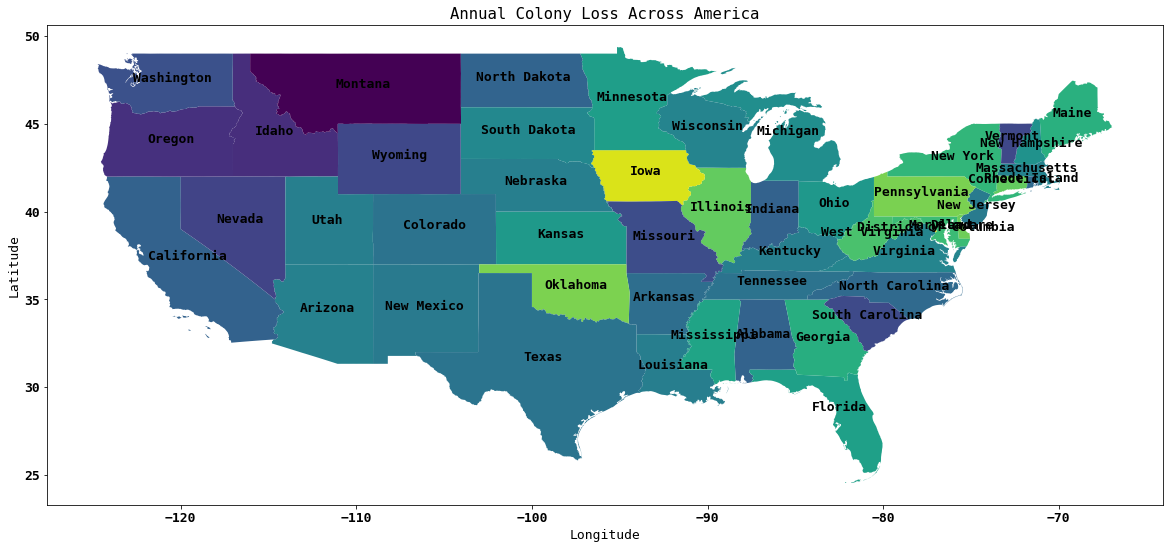

In [872]:
fig, ax = plt.subplots(1, figsize=(20,10))
c48.plot(ax=ax, column='TotalAnnualLoss', cmap='viridis', alpha=1);
plt.title("Annual Colony Loss Across America")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for idx, row in c48.iterrows():
    plt.annotate(s=row.NAME, xy=tuple(row.centroid.coords)[0], horizontalalignment='center')

## Do low beekeeper numbers relative to bee colonies contribute to colony loss? 

Dividing total colony count by the number of beekeepers for each state to get the number of bee colonies per beekeeper. Column names were changed in order to easily differentiate between columns.

In [874]:
ColoniesPerBeekeeper = c48[['Colonies']].div(c48.Beekeepers, axis=0).round(decimals=3)
c48_divided = pd.merge(c48, ColoniesPerBeekeeper, how='outer', on='GEO_ID')

c48_divided.columns = [x.replace('Colonies_x', 'Colonies') for x in c48_divided.columns]
c48_divided.columns = [x.replace('Colonies_y', 'ColoniesPerBeekeeper') for x in c48_divided.columns]

In [875]:
c48_divided.sort_values(['ColoniesPerBeekeeper'], ascending=False, inplace=True)
c48_divided.head(5)

,STATE,NAME,geometry,TotalAnnualLoss,Beekeepers,Colonies,centroid,ColoniesPerBeekeeper
GEO_ID,,,,,,,,
0400000US38,38,North Dakota,"POLYGON ((-98.72437499999999 45.938686, -98.90...",0.361,22.286,184978.714,POINT (-100.4693145518327 47.4463360194692),8300.220
0400000US46,46,South Dakota,"POLYGON ((-104.054487 44.180381, -104.055389 4...",0.418,11.000,74748.500,POINT (-100.2304894509275 44.43615201927111),6795.318
0400000US31,31,Nebraska,"POLYGON ((-104.053249 41.001406, -104.053158 4...",0.403,11.571,54358.000,POINT (-99.81080404075655 41.52714563993714),4697.779
0400000US28,28,Mississippi,"(POLYGON ((-89.095623 30.231767, -89.077259 30...",0.463,14.667,63856.167,POINT (-89.66511602166713 32.75043647817311),4353.731
0400000US16,16,Idaho,"POLYGON ((-111.044156 43.020052, -111.044129 4...",0.289,31.857,76720.286,POINT (-114.6593261430155 44.38912386399374),2408.271


Text(243.25, 0.5, 'Latitude')

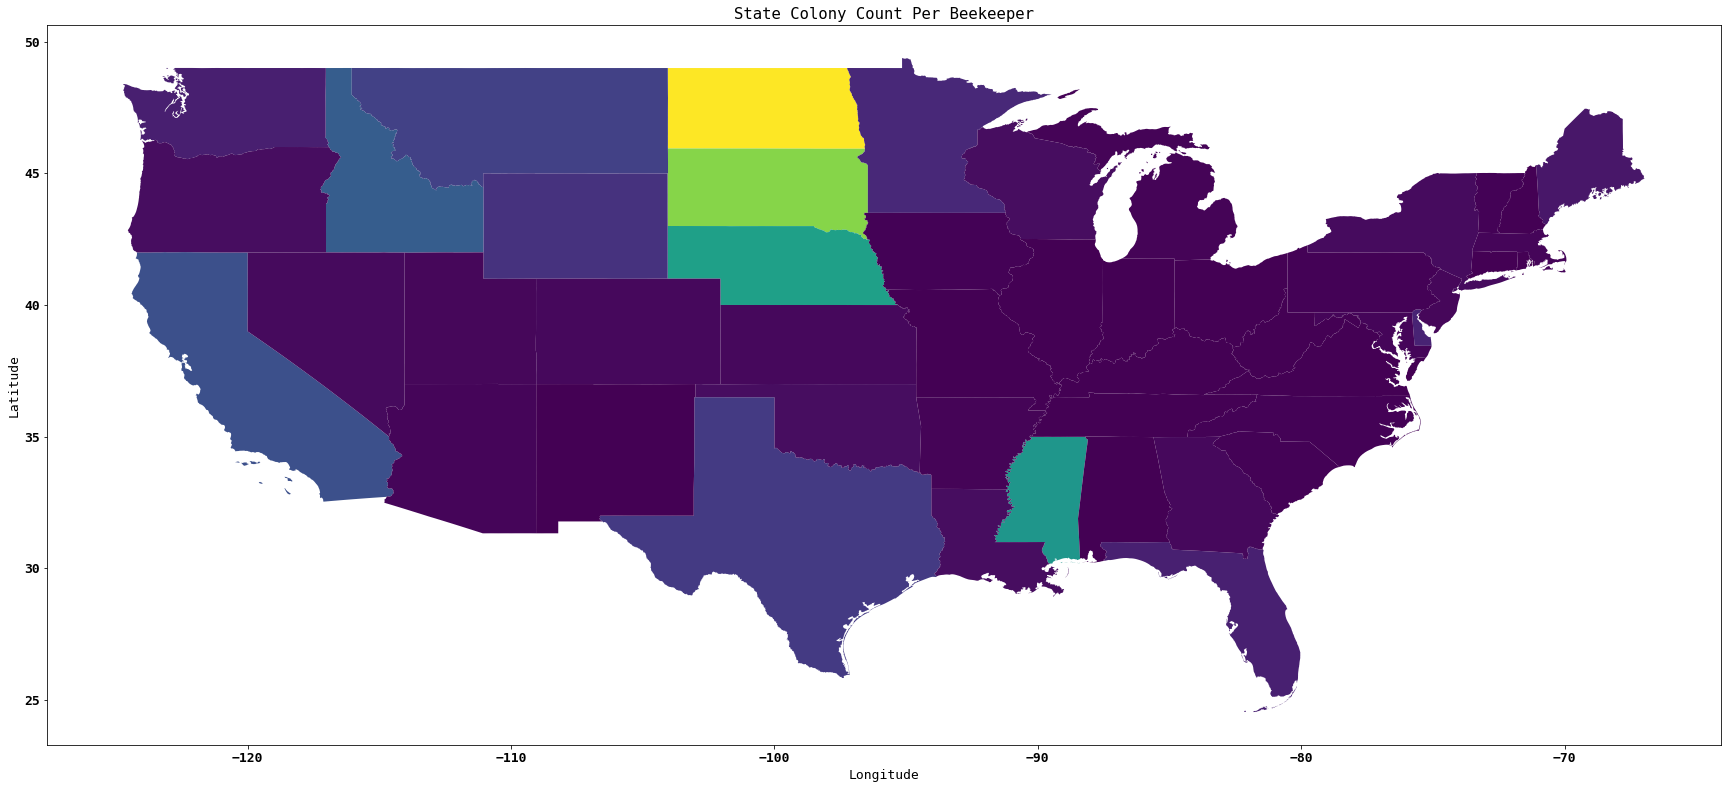

In [876]:
fig, ax = plt.subplots(1, figsize=(30,20))
c48_divided.plot(ax=ax, column='ColoniesPerBeekeeper', cmap='viridis', alpha=1);
plt.title("State Colony Count Per Beekeeper")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## What other factors might effect bee death counts?
### A new dataset is needed!

### The New Dataset

In [878]:
health_data = pd.read_csv('bee_data.csv')
health_data.sample(5)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
2350,031_088.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker
2888,010_757.png,8/19/18,12:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
1329,005_400.png,7/7/18,12:56,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
2149,046_140.png,8/19/18,15:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
2664,010_690.png,8/19/18,12:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker


Removing Unnecessary Data

In [879]:
health_data = health_data.drop(['file', 'date', 'time', 'zip code', 'pollen_carrying', 'caste'], axis=1)
health_data.columns = [x.replace('location', 'NAME') for x in health_data.columns]

In [880]:
health_data = health_data.replace(to_replace =
                                  ["Athens, GA, USA", "Athens, Georgia, USA"],
                                  value ="Georgia")
health_data = health_data.replace(to_replace =
                                  ["Saratoga, CA, USA"],
                                  value ="California")
health_data = health_data.replace(to_replace =
                                  ["Alvin, TX, USA"],
                                  value ="Texas")
health_data = health_data.replace(to_replace =
                                  ["Des Moines, IA, USA"],
                                  value ="Iowa")
health_data = health_data.replace(to_replace =
                                  ["New Orleans, LA, USA"],
                                  value ="Louisiana")
health_data = health_data.replace(to_replace =
                                  ["San Jose, CA, USA"],
                                  value ="California")
health_data = health_data.replace(to_replace =
                                  ["Keene, NH, USA"],
                                  value ="New Hampshire")
health_data = health_data.replace(to_replace =
                                  ["few varrao, hive beetles"],
                                  value ="Varroa, Small Hive Beetles")
health_data = health_data.replace(to_replace =
                                  ["-1"],
                                  value ="Unknown bee type")

### Grouping Data by Health and State Name

In [887]:
health_data['counts_health'] = health_data.groupby(['NAME', 'health'])['NAME'].transform('count')
health_data.sort_values("NAME", inplace = True)
health_data.drop_duplicates(keep = 'first', inplace = True)
health_data.head(12)

,NAME,subspecies,health,counts_health
2585,California,Italian honey bee,healthy,2
5170,California,Unknown bee type,healthy,2
4417,Georgia,1 Mixed local stock 2,"Varroa, Small Hive Beetles",2
514,Georgia,Italian honey bee,"Varroa, Small Hive Beetles",2
4076,Iowa,Russian honey bee,healthy,3
2979,Iowa,Carniolan honey bee,healthy,3
5146,Iowa,Western honey bee,healthy,3
665,Louisiana,VSH Italian honey bee,healthy,1
1953,New Hampshire,Russian honey bee,healthy,1
9,Texas,Unknown bee type,hive being robbed,1


### Merging the Data for Geographical Plotting

the counts

In [869]:
health_data.drop_duplicates(subset = ['counts_health'], keep = 'first', inplace = True)
health_data.set_index("NAME")
country_health = pd.merge(country, health_data, how='outer', on='NAME')
country_health.sample(5)

,GEO_ID,STATE,NAME,geometry,subspecies,health,counts_health
23,0400000US27,27,Minnesota,"POLYGON ((-92.204691 46.704041, -92.205692 46....",NaN,NaN,NaN
47,0400000US50,50,Vermont,"POLYGON ((-72.433796 43.232999, -72.434466 43....",NaN,NaN,NaN
17,0400000US21,21,Kentucky,"(POLYGON ((-89.485106 36.497692, -89.492537 36...",NaN,NaN,NaN
0,0400000US01,01,Alabama,"(POLYGON ((-88.124658 30.28364, -88.0868119999...",NaN,NaN,NaN
43,0400000US48,48,Texas,"(POLYGON ((-97.134356 27.896329, -97.1336 27.8...",Unknown bee type,hive being robbed,251.0


### Finding Centroids for Geographic Plotting

The 'ishere' column is to give a boolean value of whether the state exists within the health dataset, thereby giving geographical locations for 

In [870]:
def state_centroid(row):
    return row.geometry.centroid

country_health["centroid"] = country_health.apply(state_centroid, axis=1)
country_health["ishere"] = np.where(country_health.subspecies.isnull(), 0, 1)
country_health = country_health[country_health['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False]

country_health.dropna - removes all rows with a NaN value, this is so that the state NAME labels do not include NaNs.

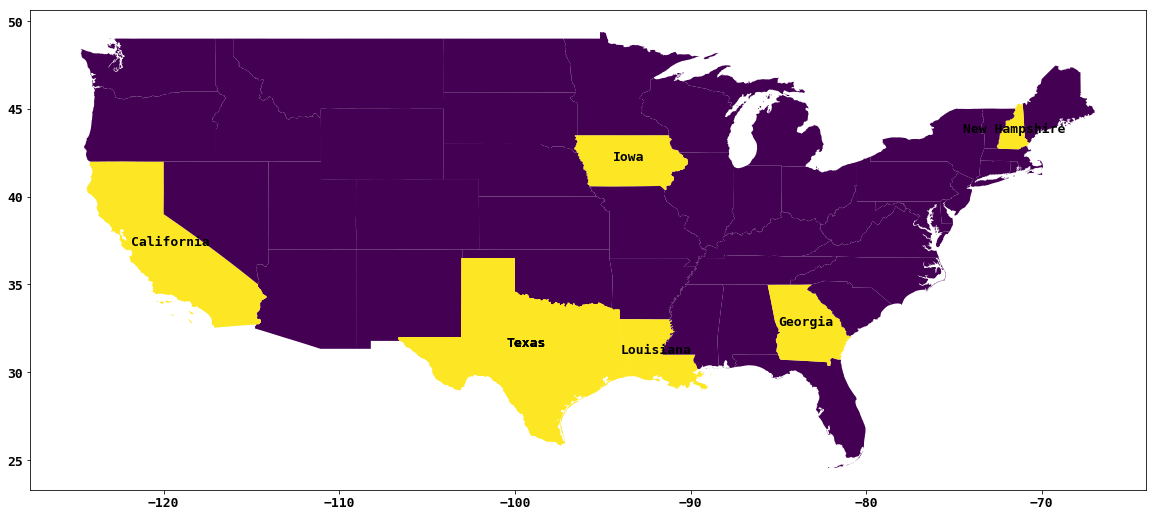

In [871]:
fig, ax = plt.subplots(1, figsize=(20,10))
country_health.plot(ax=ax, column='ishere', cmap='viridis', alpha=1);
country_health.dropna(how='any',axis='index', inplace=True)#removes all rows with a NaN value

for idx, row in country_health.iterrows():
    plt.annotate(s=row.NAME,
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center')